# SOLVRO rekrutacja zimowa ML 2022/2023


    * TARGET: Learn model to predict diffrent kinds of diffusion
    * Problem type: **Multi-class classification**
    * Evaluation metric: **F1-Score** 
    * Goal: Beat Leaderboard Benchmark ~81% 
    * Dataset: https://www.kaggle.com/competitions/solvro-rekrutacja-zimowa-ml-2022/data
    
Kinds of diffusion: 
* Klasa 0: attm - annealed transit time
* Klasa 1: crtw - continuous time random walks
* Klasa 2: fbm - fractional browian motion
* Klasa 3: lw - levy walks
* Klasa 4: sbm - scaled brownian motion

#### Load dependencies

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.metrics import confusion_matrix
from helper_functions import normalize_data, make_confusion_matrix, plot_loss_curves, calculate_results
from model import final_model

#### Load data

In [3]:
# Load train data
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")

# Load val data
X_val = np.load("data/X_val.npy")
y_val = np.load("data/y_val.npy")

# Load test data
X_test = np.load("data/X_test.npy")

#### Explore data

In [4]:
# Check data types
X_train.dtype, X_val.dtype, X_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

In [5]:
# Check data shape
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((49000, 300, 2), (49000, 5), (21000, 300, 2), (21000, 5), (30000, 300, 2))

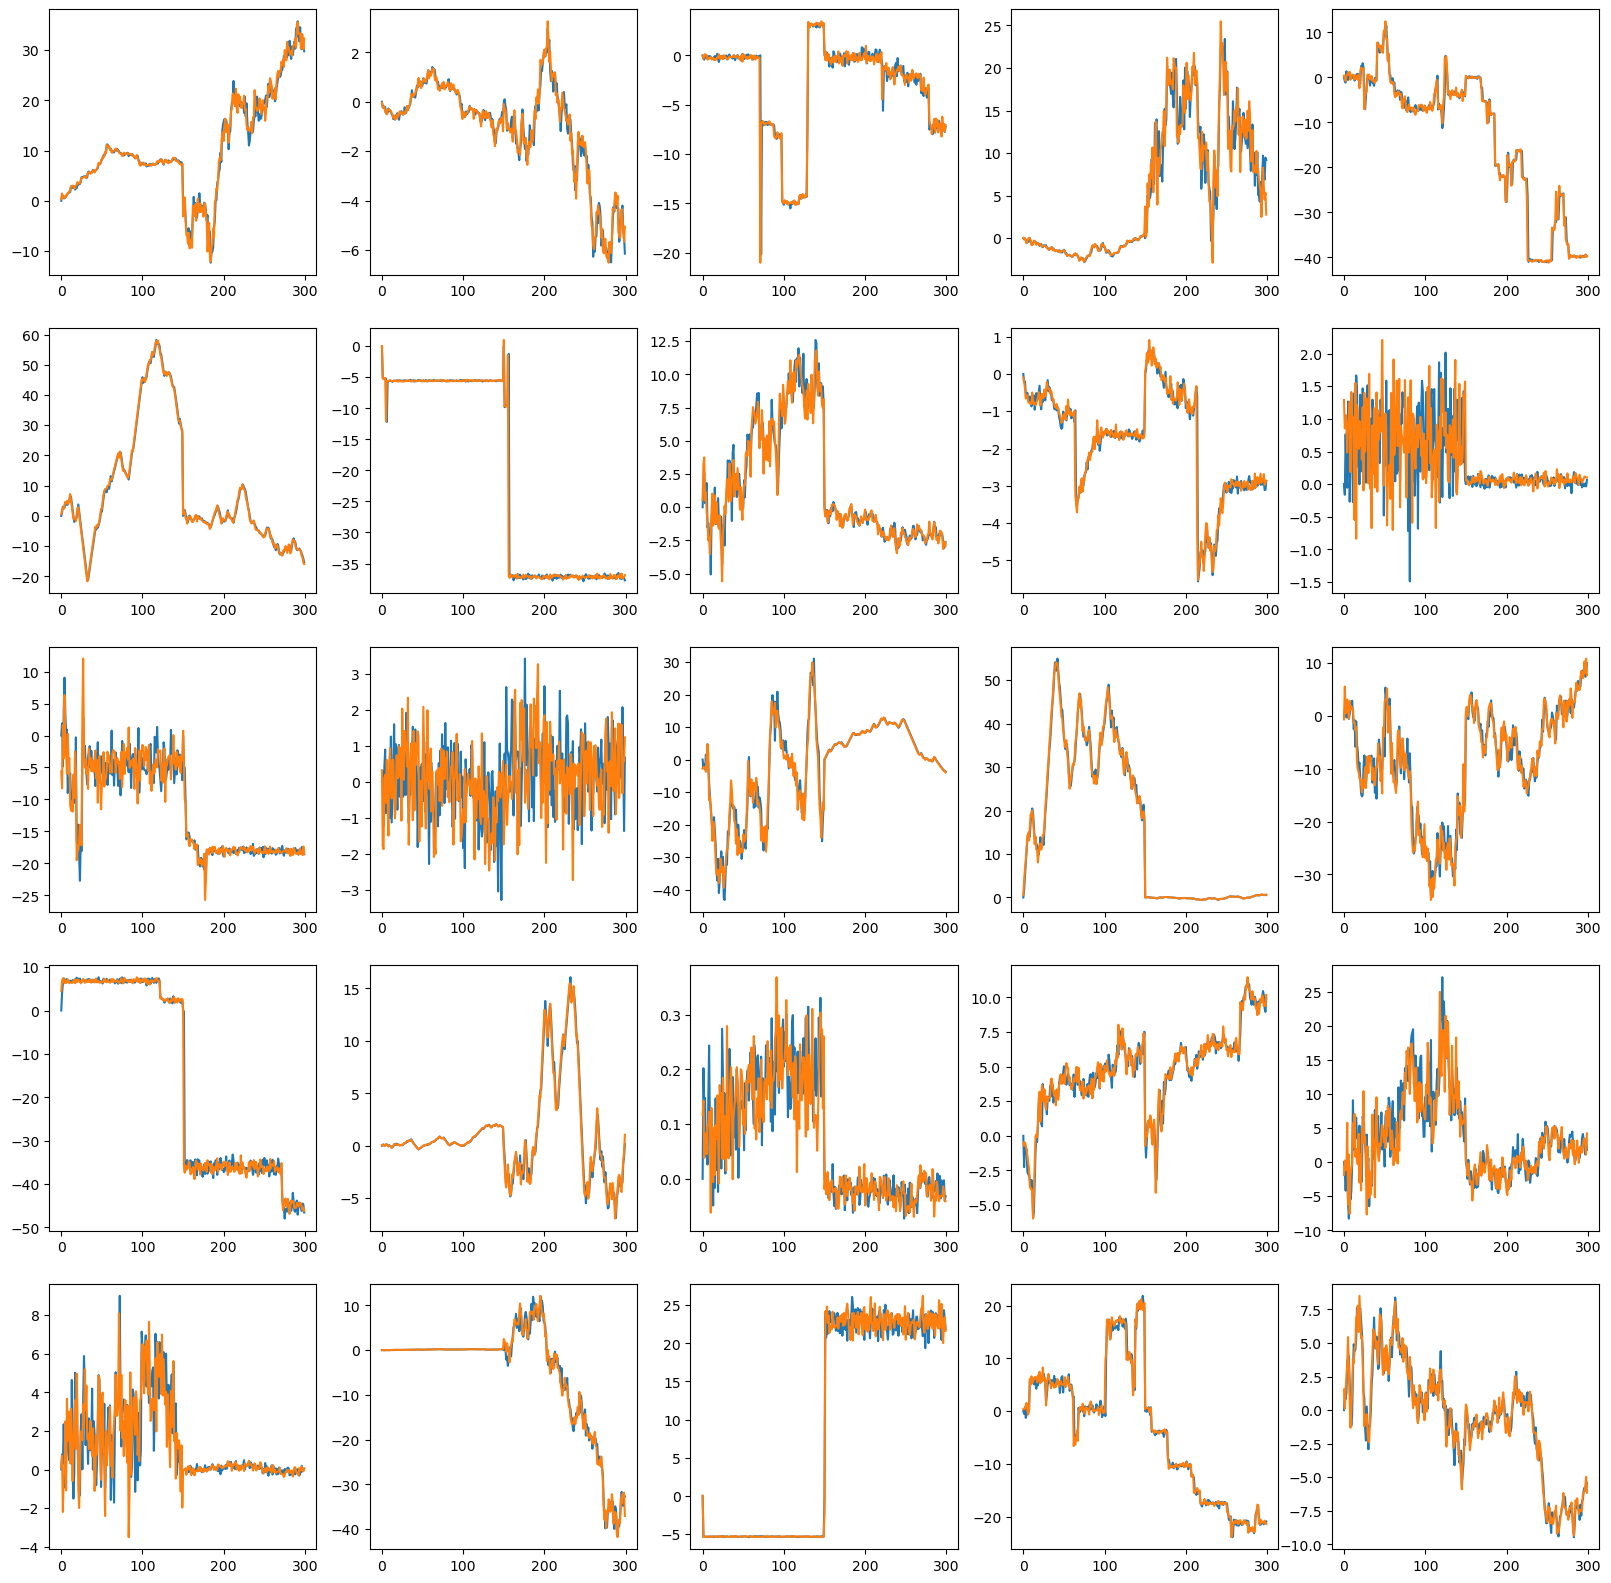

In [6]:
# plot some samples of data
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.plot(X_train[i])
plt.show()

We can see that our data has different scales and because of that we have to individually normalize every sample.

Why? 
* Thanks to this, our convolutional networks will learn better. It is about initialization of weights (glorat distribution)

#### Preprocess data

In [7]:
# normalize and change type
X_train = normalize_data(X_train).astype('float32')
X_val = normalize_data(X_val).astype('float32')
X_test = normalize_data(X_test).astype('float32')

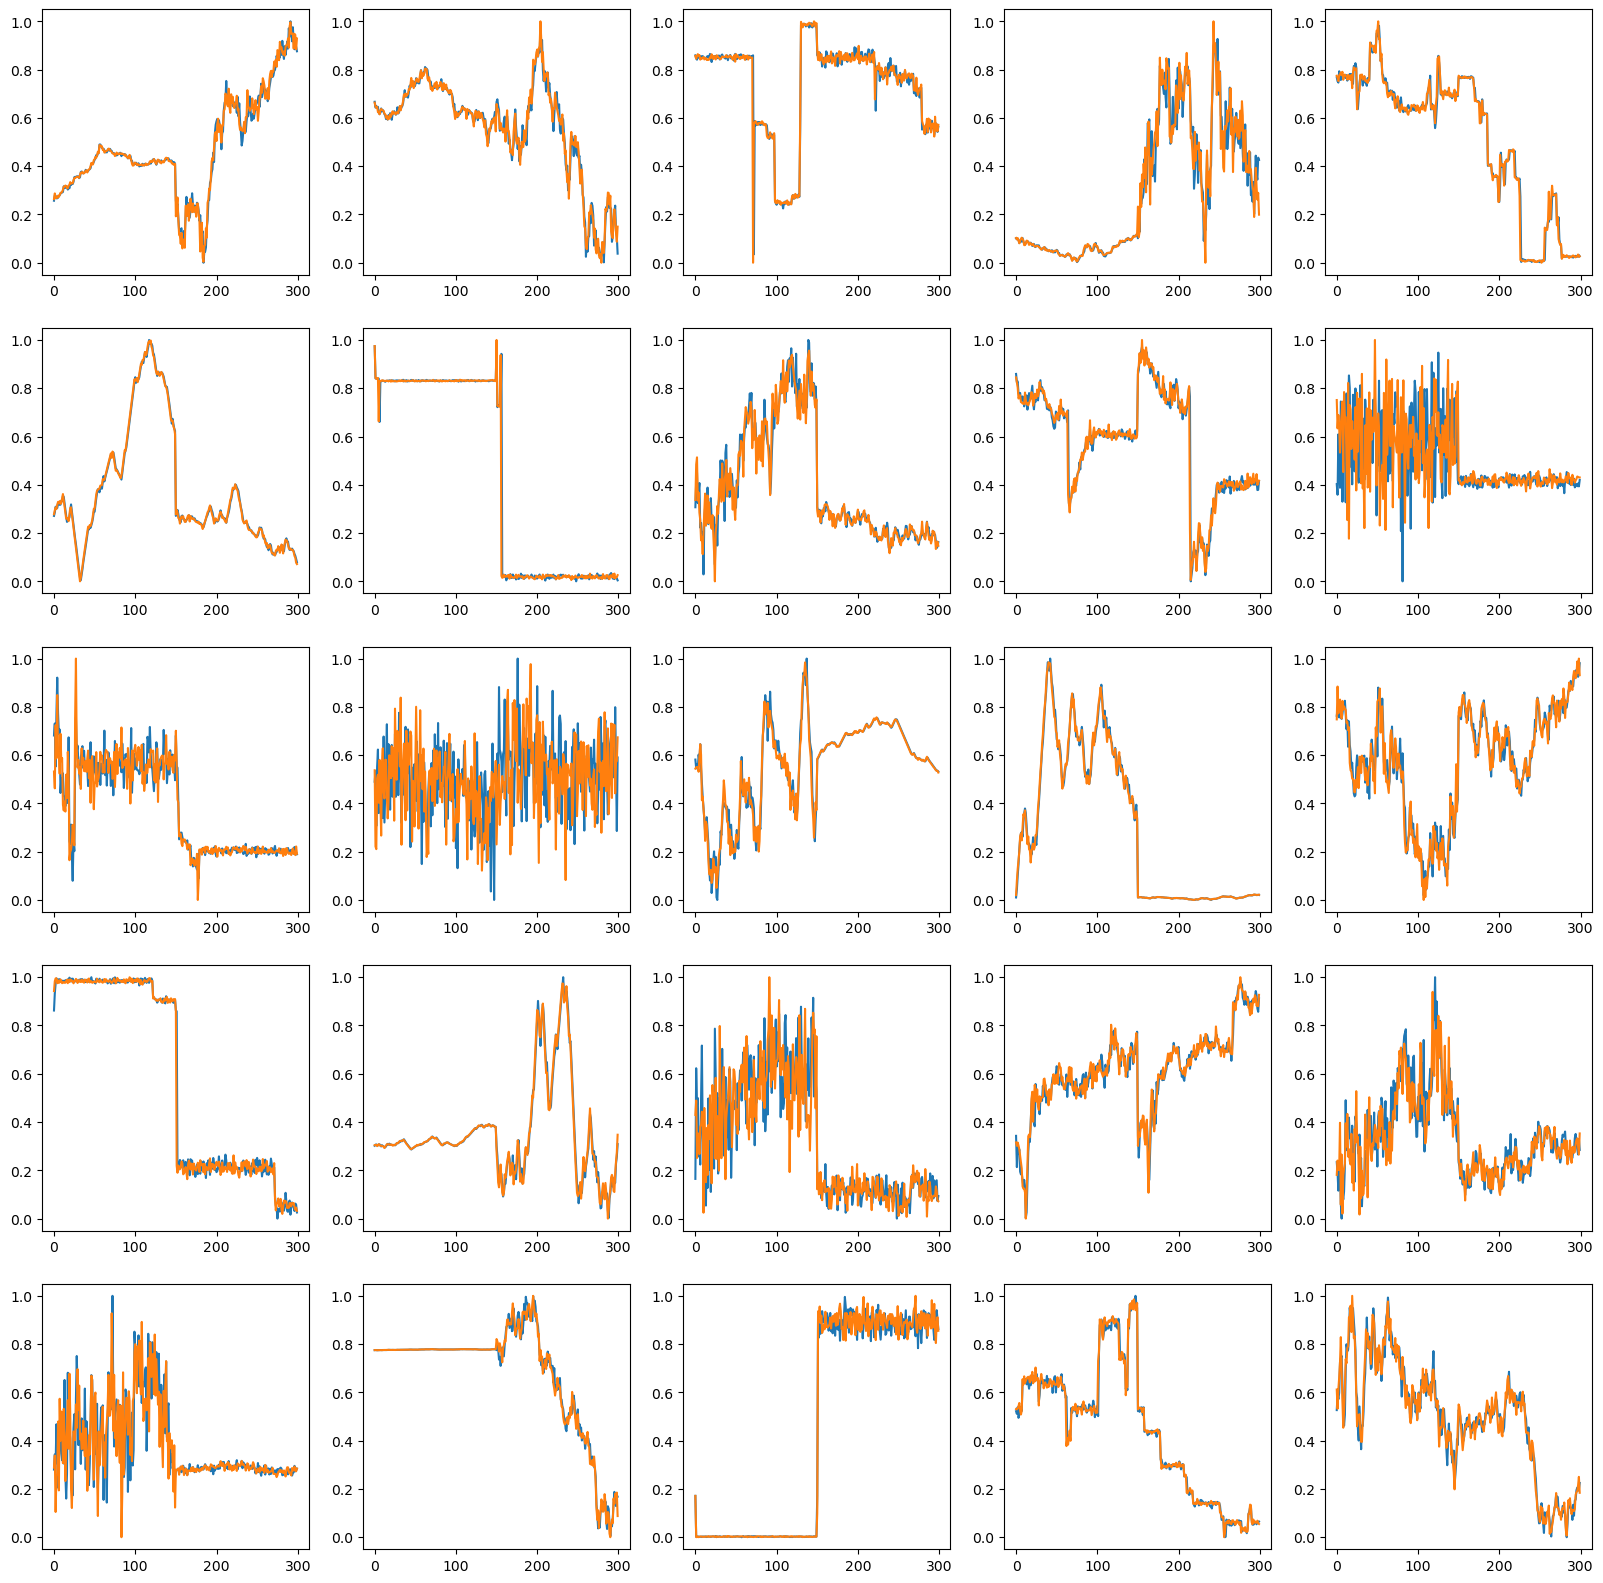

In [8]:
# check results
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.plot(X_train[i])
plt.show()

#### Set hyperparameters

In [9]:
# model architecture
n_classes = y_train.shape[1]
input_data = (300, 2)
kernel_size = 3
padding = 'same'
dropout = [0.25, 0.5]

# training
epochs = 150
batch_size = 32

#### Create callbacks

In [10]:
# prepare model saving directory
save_dir = os.path.join(os.getcwd(), 'competetive_model_huber')
model_name = 'competetive_model_huber.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [11]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-8)
# save weights for future use (e.g. reload parameters w/o training)
model_checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# stop if our model doesn't improve
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               mode='auto',
                               restore_best_weights=True)

# tensorboard = TensorBoard(log_dir=f'{filepath}/logs')

In [12]:
callbacks = [lr_reducer, model_checkpoint, early_stopping]

#### Create a model

Firstly I tried with a simpler models but i really wanted to beat this benchmark so I add more convolutional layers and filters. I added a dropout layers to prevent overfiting.

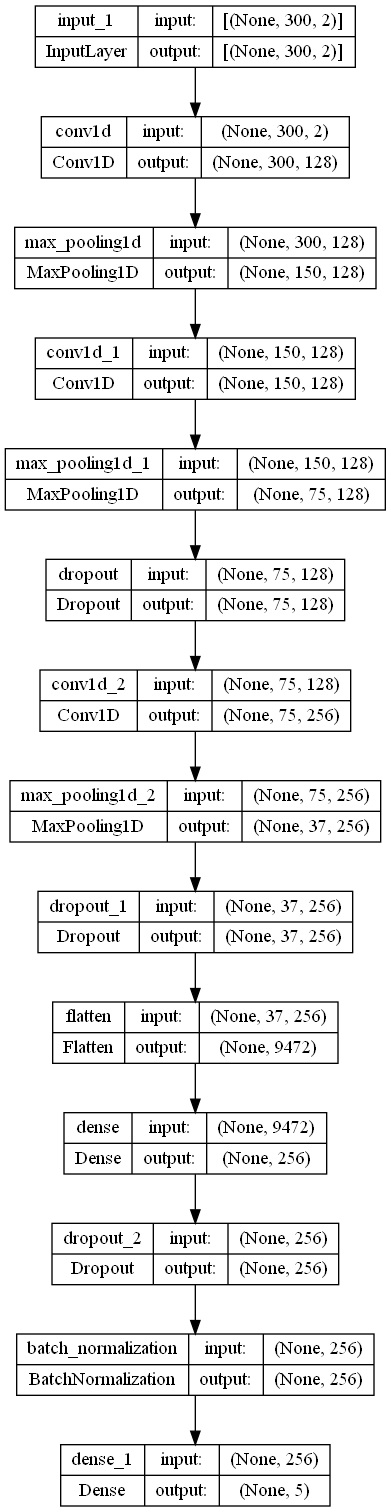

In [13]:
model = final_model(input_data, kernel_size, dropout, padding, n_classes)
plot_model(model, show_shapes=True, to_file='model.png')

#### Compile model

* It was really hard to choose between mse and huber loss function, but finally I decided on huber due to higher evaluation values. Hovewer we loss on time due to higher computational complexity.
* I also decreased learning rate because I noticed that in initial steps it can jumps over local minima.

In [14]:
model.compile(loss=tf.keras.losses.huber,
              optimizer=tf.keras.optimizers.Nadam(0.0001),
              metrics=['accuracy'])

#### Fit the model

In [16]:
baseline_history = model.fit(X_train,
                             y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=[X_val, y_val],
                             callbacks=callbacks,
                             verbose=1)

Epoch 1/150
1532/1532 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.4312
Epoch 1: val_loss improved from inf to 0.06781, saving model to C:\Users\ZEPHYRUS\Desktop\solvro_recrutation\competetive_model_huber\competetive_model_huber.001.h5
1532/1532 [==============================] - 29s 13ms/step - loss: 0.0688 - accuracy: 0.4312 - val_loss: 0.0678 - val_accuracy: 0.4787 - lr: 1.0000e-04
Epoch 2/150
1529/1532 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.6026
Epoch 2: val_loss improved from 0.06781 to 0.05280, saving model to C:\Users\ZEPHYRUS\Desktop\solvro_recrutation\competetive_model_huber\competetive_model_huber.002.h5
1532/1532 [==============================] - 20s 13ms/step - loss: 0.0523 - accuracy: 0.6027 - val_loss: 0.0528 - val_accuracy: 0.6050 - lr: 1.0000e-04
Epoch 3/150
1529/1532 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.6451
Epoch 3: val_loss did not improve from 0.05280
1532/1532 [=========

1530/1532 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.8240
Epoch 24: val_loss did not improve from 0.02412
1532/1532 [==============================] - 22s 14ms/step - loss: 0.0248 - accuracy: 0.8240 - val_loss: 0.0254 - val_accuracy: 0.8160 - lr: 3.1623e-05
Epoch 25/150
1532/1532 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.8258
Epoch 25: val_loss did not improve from 0.02412
1532/1532 [==============================] - 22s 14ms/step - loss: 0.0245 - accuracy: 0.8258 - val_loss: 0.0244 - val_accuracy: 0.8219 - lr: 3.1623e-05
Epoch 26/150
1529/1532 [============================>.] - ETA: 0s - loss: 0.0240 - accuracy: 0.8289
Epoch 26: val_loss improved from 0.02412 to 0.02362, saving model to C:\Users\ZEPHYRUS\Desktop\solvro_recrutation\competetive_model_huber\competetive_model_huber.026.h5
1532/1532 [==============================] - 23s 15ms/step - loss: 0.0240 - accuracy: 0.8290 - val_loss: 0.0236 - val_accuracy: 0.8273 - lr: 3.1

Epoch 49/150
1532/1532 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.8595
Epoch 49: val_loss did not improve from 0.02220
1532/1532 [==============================] - 21s 13ms/step - loss: 0.0200 - accuracy: 0.8595 - val_loss: 0.0243 - val_accuracy: 0.8220 - lr: 1.0000e-05
Epoch 50/150
1531/1532 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.8592
Epoch 50: ReduceLROnPlateau reducing learning rate to 3.162277292675049e-06.

Epoch 50: val_loss did not improve from 0.02220
1532/1532 [==============================] - 93s 60ms/step - loss: 0.0201 - accuracy: 0.8593 - val_loss: 0.0227 - val_accuracy: 0.8350 - lr: 1.0000e-05
Epoch 51/150
1532/1532 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.8626
Epoch 51: val_loss did not improve from 0.02220
1532/1532 [==============================] - 21s 14ms/step - loss: 0.0196 - accuracy: 0.8626 - val_loss: 0.0228 - val_accuracy: 0.8332 - lr: 3.1623e-06
Epoch 52/150
1531/1532

#### Evaluate

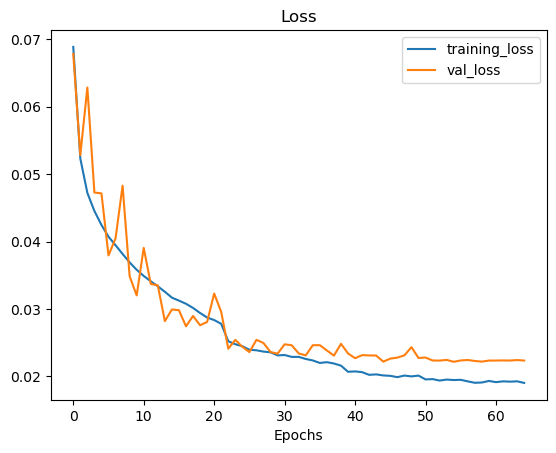

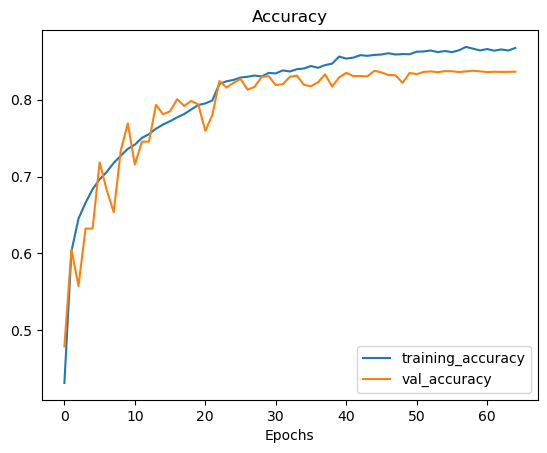

In [17]:
plot_loss_curves(baseline_history)

* We can see that our model a few times trapped in local minimum, so reduce the learning rate was good approach


In [18]:
model.evaluate(X_val, y_val)

657/657 [==============================] - 3s 4ms/step - loss: 0.0222 - accuracy: 0.8373


[0.022174468263983727, 0.8373333215713501]

In [19]:
y_pred = model.predict(X_val)

657/657 [==============================] - 1s 2ms/step


In [21]:
y_labels_pred = []
for i in range(len(y_pred)-1):
    y_labels_pred.append(y_pred[i].argmax())

In [22]:
y_labels_true = []
for i in range(len(y_val)-1):
    y_labels_true.append(y_val[i].argmax())

In [23]:
calculate_results(y_labels_true, y_labels_pred)

{'accuracy': 83.73732082480117,
 'precision': 0.8398118656106032,
 'recall': 0.8373732082480118,
 'f1': 0.8343089876074924}

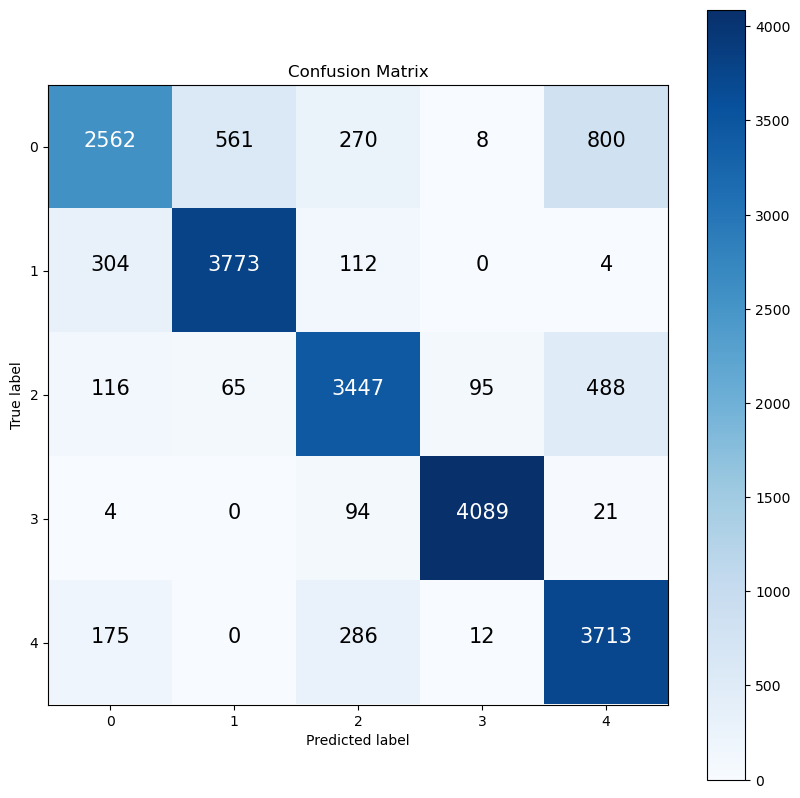

In [24]:
make_confusion_matrix(y_labels_true, y_labels_pred)

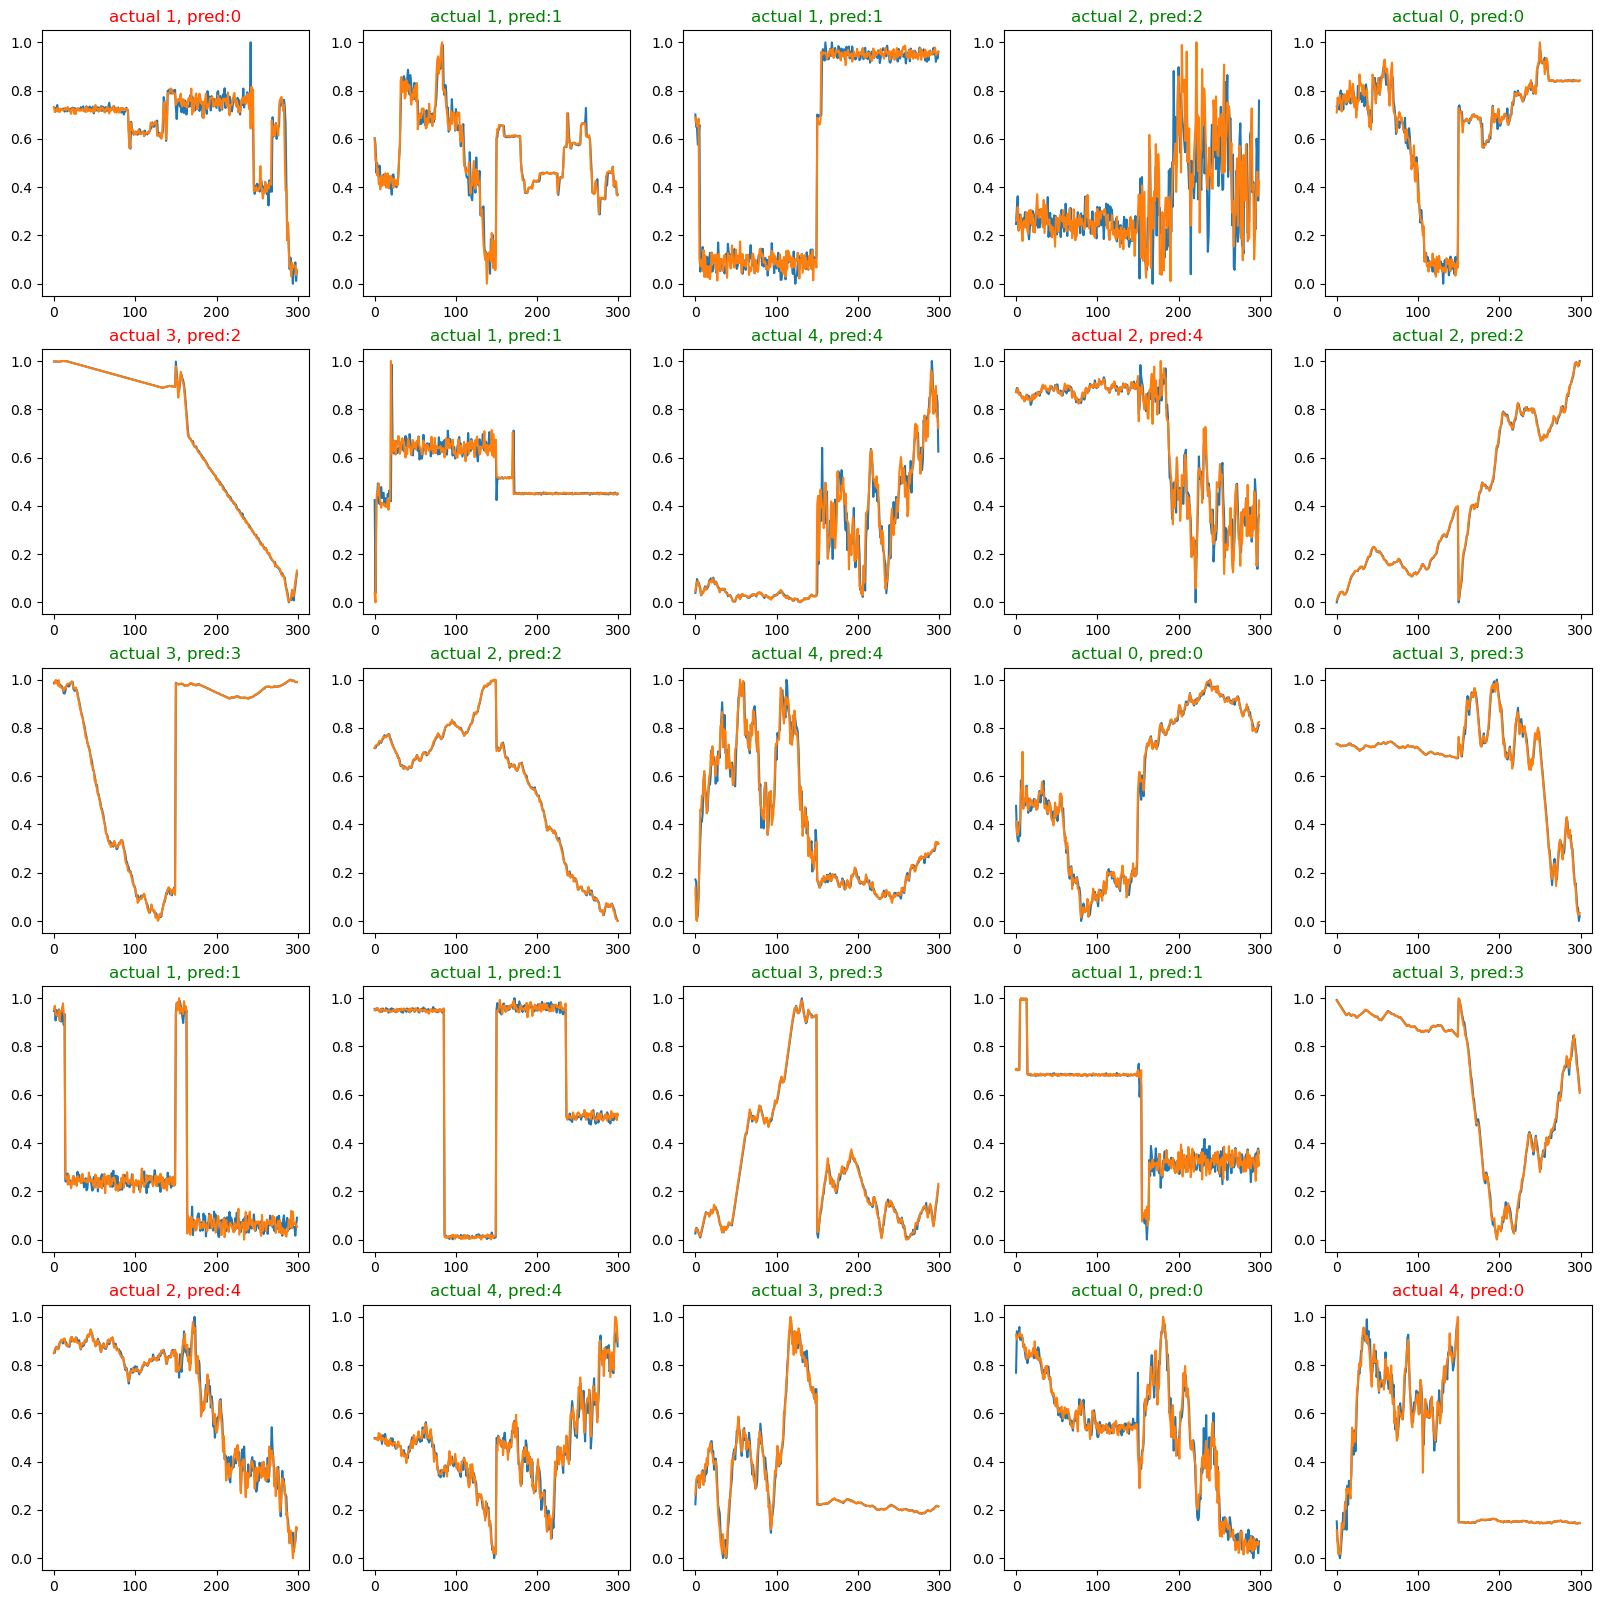

<Figure size 640x480 with 0 Axes>

In [34]:
import random
# plot some samples of data
plt.figure(figsize=(20, 20))
for i in range(25):
    number = random.randint(0, len(y_val))
    plt.subplot(5, 5, i+1)
    plt.plot(X_val[number])
    if y_val[number].argmax() == y_pred[number].argmax():
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f"actual {y_val[number].argmax()}, pred:{y_pred[number].argmax()}",
             c=title_color)
plt.show()
plt.savefig("results.png")

#### I could also find the most wrong predictions in our model and try to fix it, but personally i don't have enough knowledge about different types of difussion